# Experiments

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
#pd.options.display.max_columns = None
#pd.set_option("display.max_colwidth", None)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
#pd.set_option("display.max_rows", None)
import model.train as train
import model.config as model_config
import utils
import model.dataset.game_matchup as gm
import experiments as exp

## Load Dataset

In [2]:
gm_df = gm.load_game_matchup_dataset()

## Experiment using TimeSeriesSplit

### Specific imports

In [3]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import precision_score, recall_score, balanced_accuracy_score

### Dataset

Usando max_split en TimeSeriesSplit permite dividir el dataset por cantidad de filas por lo que vamos a escoger 
solo las temporadas que tiene la misma cantiadad de partidos.


In [4]:
gm_df.groupby(by="SEASON").count()["GAME_DATE_EST"]

SEASON
2003    1189
2004    1230
2005    1230
2006    1230
2007    1230
2008    1230
2009    1230
2010    1230
2011     990
2012    1229
2013    1230
2014    1230
2015    1230
2016    1230
2017    1230
2018    1230
Name: GAME_DATE_EST, dtype: int64

Podemos observar que no todas las temporadas tiene la misma cantidad de partidos esto es debido a la siguientes razones:

- 2011: Los jugadores hicieron una huelga debido a no estar de acuerdo con los salarios de los mismos y el limite salarial de las franquicias.
- 2012: Un partido entre el equipo de Boston e Indiana fue suspedindo el cual despues no fue reprogramado, y al final de la temporada se decidio ya no reprogramarlo debido a qu la clasificacion a playoff ya estaba decidida y no afectaba el resultado.

Por tanto se seleccionaran solo las temporadas a partir del 2013(inclusive).

In [5]:
df = gm_df[gm_df.SEASON >= 2013]

Prueba de como seran dividido el dataset usando TimeSeriesSplit

In [6]:
tscv = TimeSeriesSplit(n_splits=len(df.SEASON.unique())-1, max_train_size=1230)
X, y = train.X_y_values(df, model_config.X_for_scale, model_config.y_columns[-1:])
print(len(X))
for train_index, test_index in tscv.split(X=X):
    print("TRAIN:", train_index, "TEST:", test_index)

7380
TRAIN: [   0    1    2 ... 1227 1228 1229] TEST: [1230 1231 1232 ... 2457 2458 2459]
TRAIN: [1230 1231 1232 ... 2457 2458 2459] TEST: [2460 2461 2462 ... 3687 3688 3689]
TRAIN: [2460 2461 2462 ... 3687 3688 3689] TEST: [3690 3691 3692 ... 4917 4918 4919]
TRAIN: [3690 3691 3692 ... 4917 4918 4919] TEST: [4920 4921 4922 ... 6147 6148 6149]
TRAIN: [4920 4921 4922 ... 6147 6148 6149] TEST: [6150 6151 6152 ... 7377 7378 7379]


### Algorithms 

In [7]:
models = []
models.append(('KNN', KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2))) 
models.append(('SVM', SVC(kernel = 'linear', random_state=0))) 
models.append(('KSVM', SVC(kernel = 'rbf', random_state=0))) 
models.append(('NB', GaussianNB())) 
models.append(('DT', DecisionTreeClassifier(criterion = 'entropy', random_state=0))) 
models.append(('SGD', SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)))
models.append(("RF", RandomForestClassifier(n_estimators=500, 
                                            max_features="sqrt", 
                                            max_depth=15, 
                                            n_jobs=-1, 
                                            random_state = 0)))
models.append(("GB", GradientBoostingClassifier(n_estimators=500, 
                                                max_depth=15, 
                                                max_features="sqrt", 
                                                random_state = 0)))

### Run experiments

In [8]:
# TimeSeries Cross validation
train_splits = len(df.SEASON.unique()) - 1
tscv = TimeSeriesSplit(n_splits=train_splits, max_train_size=1230)
X, y = train.X_y_values(df, model_config.X_for_scale, model_config.y_columns[-1:])
params = ("using cross validate", df, models, tscv, train_splits, X, y)
names, results = exp.run_experiment_using_cross_validate(*params)

Start experiment using TimeSeriesSplit
KNN
test_balanced_accuracy: 0.638266173950692 - 0.012388548927403384
test_precision: 0.6942680356832144 - 0.017505301008140333
test_recall: 0.724577598245685 - 0.022356353939272176
SVM
test_balanced_accuracy: 0.7023793333572499 - 0.0205945882026663
test_precision: 0.7482881939852426 - 0.025285553913787593
test_recall: 0.7679533131391177 - 0.022664541178818668
KSVM
test_balanced_accuracy: 0.5 - 0.0
test_precision: 0.583739837398374 - 0.006442800896311838
test_recall: 1.0 - 0.0
NB
test_balanced_accuracy: 0.5899128794081088 - 0.054987549636554764
test_precision: 0.7126896373971718 - 0.07520596704245437
test_recall: 0.5162363379919036 - 0.32392254012995275
DT
test_balanced_accuracy: 0.5987766568270589 - 0.032922491841477435
test_precision: 0.6720135872881385 - 0.039669083081313755
test_recall: 0.6456848486498289 - 0.03239869273645262
SGD
test_balanced_accuracy: 0.6041243073982769 - 0.09163059754111888
test_precision: 0.5423508074398653 - 0.27901908446

/home/nathaniel/anaconda3/envs/nba-predictor/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nathaniel/anaconda3/envs/nba-predictor/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RF
test_balanced_accuracy: 0.6773482090228448 - 0.016847238352939505
test_precision: 0.7199297535910129 - 0.028657320651189238
test_recall: 0.7893142897737604 - 0.04841885478602258
GB
test_balanced_accuracy: 0.6858947564551707 - 0.02129190199516734
test_precision: 0.7570266645529299 - 0.029123633038190093
test_recall: 0.6806107833394385 - 0.0450727767286027
Done


### Visualize experiments results

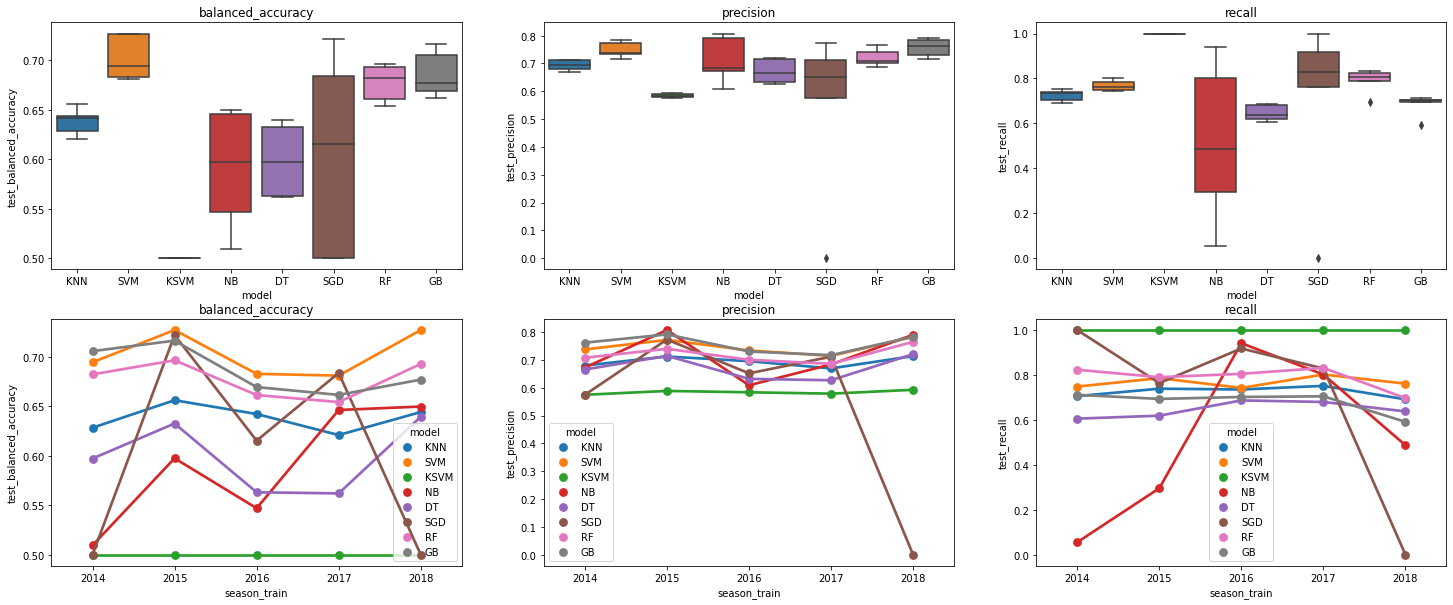

In [9]:
results_df = exp.plot_experiment_results(results)
results_df.to_pickle("./experiments/tscv_exp.pkl")

Se observa lo siguiente:

- KSVM: siempre predice true o 1, por esta razon en los graficos podemos ver como para la metrica test_balanced_accuracy mantiene un rendimiento constante de 50%, y sin embargo para la metrica test_recall observamos como muestra tambien un rendimiento constante de 100% acierto, dado que el modelo nunca produce falsos negativos.

- Se observa como los algoritmos mas estables

https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall

### Test a specific model

In [10]:
from sklearn.metrics import confusion_matrix

SVC(random_state=0)

Confusion Matrix
[[  0 523]
 [  0 707]]
Test Set: 1230
Accuracy = 57.47967479674797 %
balanced_accuracy_score: 0.5
recall_score: 1.0


Text(0.5, 1.05, 'Confusion matrix')

Text(0, 0.5, 'True label')

Text(0.5, 0, 'Predicted label')

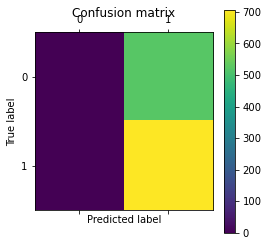

SVC(random_state=0)

Confusion Matrix
[[  0 506]
 [  0 724]]
Test Set: 1230
Accuracy = 58.86178861788618 %
balanced_accuracy_score: 0.5
recall_score: 1.0


Text(0.5, 1.05, 'Confusion matrix')

Text(0, 0.5, 'True label')

Text(0.5, 0, 'Predicted label')

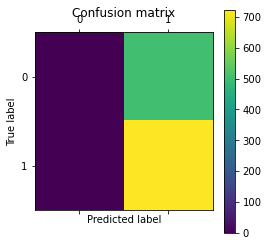

SVC(random_state=0)

Confusion Matrix
[[  0 512]
 [  0 718]]
Test Set: 1230
Accuracy = 58.3739837398374 %
balanced_accuracy_score: 0.5
recall_score: 1.0


Text(0.5, 1.05, 'Confusion matrix')

Text(0, 0.5, 'True label')

Text(0.5, 0, 'Predicted label')

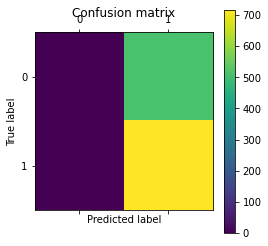

SVC(random_state=0)

Confusion Matrix
[[  0 518]
 [  0 712]]
Test Set: 1230
Accuracy = 57.886178861788615 %
balanced_accuracy_score: 0.5
recall_score: 1.0


Text(0.5, 1.05, 'Confusion matrix')

Text(0, 0.5, 'True label')

Text(0.5, 0, 'Predicted label')

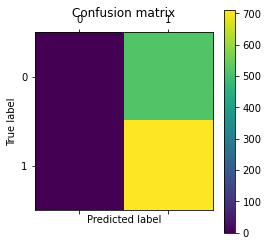

SVC(random_state=0)

Confusion Matrix
[[  0 501]
 [  0 729]]
Test Set: 1230
Accuracy = 59.26829268292683 %
balanced_accuracy_score: 0.5
recall_score: 1.0


Text(0.5, 1.05, 'Confusion matrix')

Text(0, 0.5, 'True label')

Text(0.5, 0, 'Predicted label')

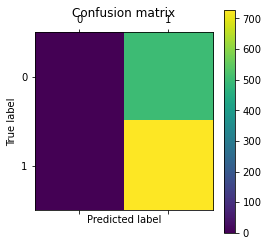

In [11]:
tscv = TimeSeriesSplit(n_splits=len(df.SEASON.unique())-1, max_train_size=1230)
X, y = train.X_y_values(df, model_config.X_for_scale, model_config.y_columns[-1:])
model = SVC(kernel = 'rbf', random_state=0)
for train_index, test_index in tscv.split(X=X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    model.fit(X[train_index], y[train_index].ravel())
    predictions = model.predict(X=X[test_index])
    percentage = model.score(X[test_index], y[test_index].ravel())
    res = confusion_matrix(y[test_index], predictions)
    print("Confusion Matrix")
    print(res)
    print(f"Test Set: {len(X[test_index])}")
    print(f"Accuracy = {percentage*100} %")
    print(f"balanced_accuracy_score: {balanced_accuracy_score(y[test_index], predictions)}")
    print(f"recall_score: {recall_score(y[test_index], predictions)}")
    # Show confusion matrix in a separate window
    plt.matshow(res)
    plt.title('Confusion matrix')
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [12]:
results_pred = np.concatenate((predictions.reshape(len(predictions),1), y[test_index].reshape(len(y[test_index]),1)),1)
test_pred = pd.DataFrame(results_pred, columns=["pred", "true"])

### Experiment using StandardScaler

In [13]:
train_splits = len(df.SEASON.unique()) - 1
tscv = TimeSeriesSplit(n_splits=len(df.SEASON.unique())-1, max_train_size=1230)
X, y = train.X_y_values(df, model_config.X_for_scale, model_config.y_columns[-1:])
names, results = exp.run_experiment("using scaler", df, models, tscv, train_splits, X, y, True)

Running experiment using scaler
KNN
balanced_accuracy: 0.6754298375027097 - 0.01928777264171135
precision: 0.6912195121951219 - 0.014234841384220686
recall: 0.7673378201765793 - 0.04960421218990976
SVM
balanced_accuracy: 0.6531617747424621 - 0.07899025362583809
precision: 0.6796747967479676 - 0.046456852490962465
recall: 0.8020006303000047 - 0.099097445715703
KSVM
balanced_accuracy: 0.5 - 0.0
precision: 0.583739837398374 - 0.006442800896311838
recall: 1.0 - 0.0
NB
balanced_accuracy: 0.5590693577229467 - 0.05445478110777875
precision: 0.5715447154471545 - 0.07701036856777327
recall: 0.6185823199078793 - 0.3769352404986154
DT
balanced_accuracy: 0.6096898572132264 - 0.02931865850088213
precision: 0.6167479674796748 - 0.023656161700152577
recall: 0.6528572611485861 - 0.021515182006140297
SGD
balanced_accuracy: 0.6757287244870449 - 0.0891919511576374
precision: 0.661951219512195 - 0.12325417764184288
recall: 0.5944387121743547 - 0.29967443458518206
RF
balanced_accuracy: 0.6753975495620412 -

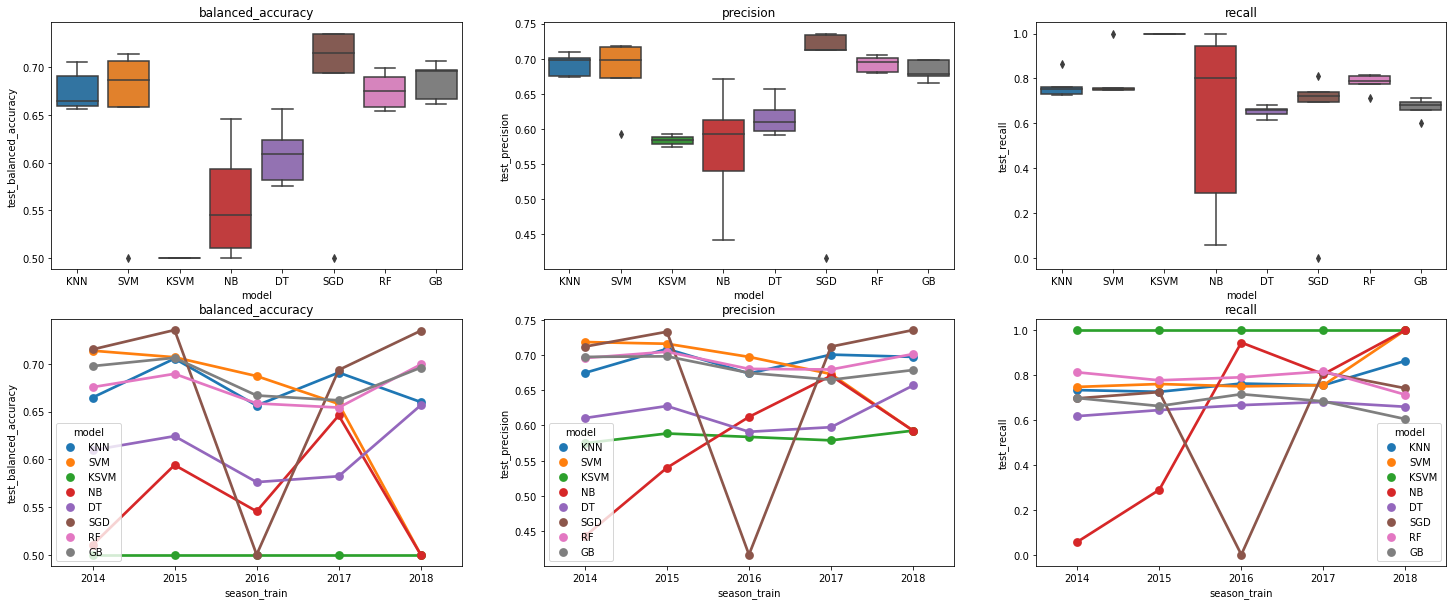

In [14]:
results_df = exp.plot_experiment_results(results)
results_df.to_pickle("./experiments/scaled_tscv_exp.pkl")

A partir de realizar los siguientes experimentos:

- Entrenar los modelos sin escalar los valores numericos.

### Experiment using 2 seasons

Usando TimeSeriesSplit visualizaremos como sera dividido el modelo

In [16]:
train_splits = len(df.SEASON.unique()) - 4
tscv = TimeSeriesSplit(n_splits=len(df.SEASON.unique())-4, max_train_size=2460)
X, y = train.X_y_values(df, model_config.X_ordinal_cols + model_config.X_num_cols, model_config.y_columns[-1:])
print(len(X))
for train_index, test_index in tscv.split(X=X):
    print("TRAIN:", train_index, "TEST:", test_index)
    
names, results = exp.run_experiment("2 seasons", df, models, tscv, train_splits, X, y)

7380
TRAIN: [   0    1    2 ... 2457 2458 2459] TEST: [2460 2461 2462 ... 4917 4918 4919]
TRAIN: [2460 2461 2462 ... 4917 4918 4919] TEST: [4920 4921 4922 ... 7377 7378 7379]
Running experiment 2 seasons
KNN
balanced_accuracy: 0.6496744452376364 - 0.009012191146560378
precision: 0.665650406504065 - 0.005487804878048785
recall: 0.7426332653487475 - 0.01170400043890002
SVM
balanced_accuracy: 0.7080086988220764 - 0.005254505252160202
precision: 0.7203252032520325 - 0.003658536585365857
recall: 0.7797595386159827 - 0.0467498298781186
KSVM
balanced_accuracy: 0.5 - 0.0
precision: 0.5859756097560975 - 0.00020325203252030688
recall: 1.0 - 0.0
NB
balanced_accuracy: 0.5550701576475352 - 0.036805305022524715
precision: 0.5453252032520325 - 0.10060975609756095
recall: 0.4992742749727853 - 0.40773474654005304
DT
balanced_accuracy: 0.6019618281933039 - 0.022659073250608674
precision: 0.6146341463414634 - 0.021138211382113803
recall: 0.675680319088012 - 0.01364006926150263
SGD
balanced_accuracy: 0.61

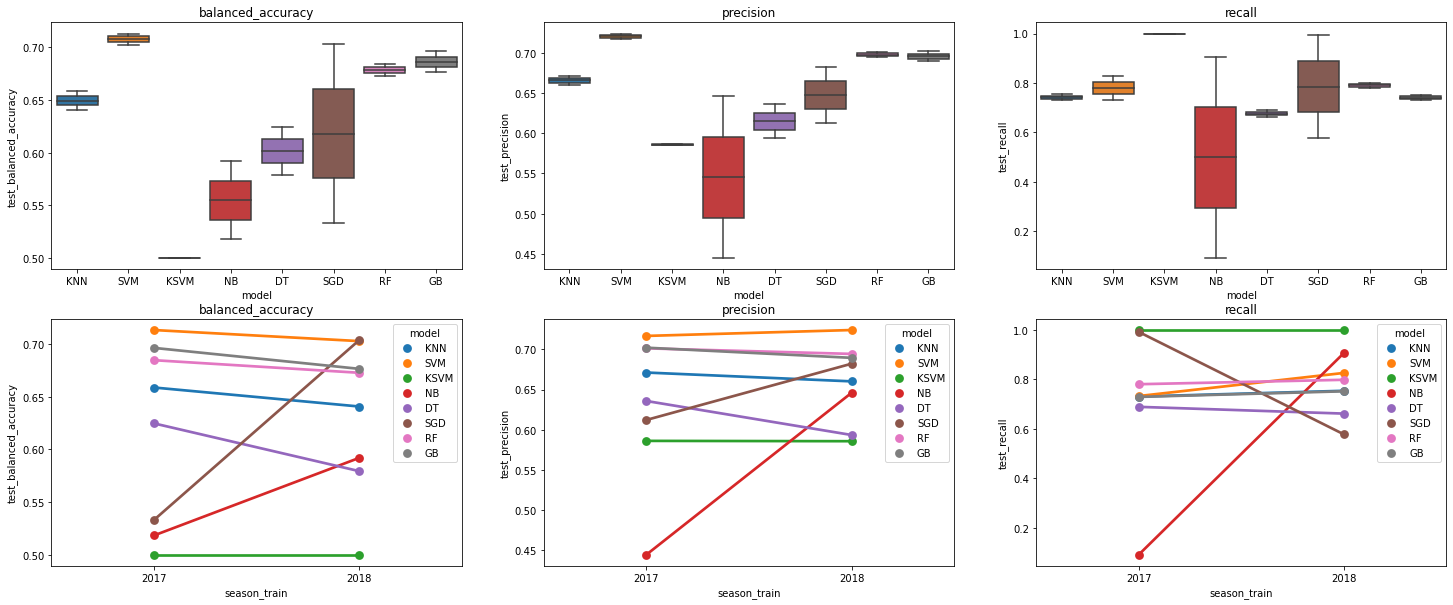

In [17]:
results_df = exp.plot_experiment_results(results)
results_df.to_pickle("./experiments/scaled_tscv_exp.pkl")

In [19]:
exp_df = pd.DataFrame(exp.exp_results)

In [24]:
exp_df.sort_values(by=["balanced_accuracy_mean"], ascending=False)

,exp_name,model,balanced_accuracy_mean,balanced_accuracy_std,precision_mean,precision_std,recall_mean,recall_std
17,2 seasons,SVM,0.708009,0.005255,0.720325,0.003659,0.779760,0.046750
1,using cross validate,SVM,0.702379,0.020595,0.748288,0.025286,0.767953,0.022665
23,2 seasons,GB,0.686363,0.009941,0.695732,0.006301,0.740899,0.011357
7,using cross validate,GB,0.685895,0.021292,0.757027,0.029124,0.680611,0.045073
15,using scaler,GB,0.685693,0.017899,0.682927,0.013079,0.671910,0.038338
22,2 seasons,RF,0.678658,0.005976,0.697764,0.003455,0.789805,0.008945
6,using cross validate,RF,0.677348,0.016847,0.719930,0.028657,0.789314,0.048419
13,using scaler,SGD,0.675729,0.089192,0.661951,0.123254,0.594439,0.299674
8,using scaler,KNN,0.675430,0.019288,0.691220,0.014235,0.767338,0.049604
14,using scaler,RF,0.675398,0.017355,0.692520,0.010555,0.781153,0.037544


In [26]:
exp_df.sort_values(by=["balanced_accuracy_std"], ascending=True)

,exp_name,model,balanced_accuracy_mean,balanced_accuracy_std,precision_mean,precision_std,recall_mean,recall_std
18,2 seasons,KSVM,0.500000,0.000000,0.585976,0.000203,1.000000,0.000000
2,using cross validate,KSVM,0.500000,0.000000,0.583740,0.006443,1.000000,0.000000
10,using scaler,KSVM,0.500000,0.000000,0.583740,0.006443,1.000000,0.000000
17,2 seasons,SVM,0.708009,0.005255,0.720325,0.003659,0.779760,0.046750
22,2 seasons,RF,0.678658,0.005976,0.697764,0.003455,0.789805,0.008945
16,2 seasons,KNN,0.649674,0.009012,0.665650,0.005488,0.742633,0.011704
23,2 seasons,GB,0.686363,0.009941,0.695732,0.006301,0.740899,0.011357
0,using cross validate,KNN,0.638266,0.012389,0.694268,0.017505,0.724578,0.022356
6,using cross validate,RF,0.677348,0.016847,0.719930,0.028657,0.789314,0.048419
14,using scaler,RF,0.675398,0.017355,0.692520,0.010555,0.781153,0.037544
